In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image, ImageDraw
from car_models import car_id2name, car_name2id, models
import cv2
import os
import sys
import pyrender
import trimesh

pose_path = "D:\\Program\\Apollo\\instance\\train\\car_poses\\"
image_path = "D:\\Program\\Apollo\\instance\\train\\images\\"
keypoint_path = "D:\\Program\\Apollo\\instance\\train\\keypoints\\"

fx=2304.54786556982
fy=2305.875668062
cx=1686.23787612802
cy=1354.98486439791

camera_matrix = np.array([[fx, 0,  cx],
                          [0,  fy, cy],
                          [0,  0,  1 ]], dtype=np.float32)

dist_coeffs = np.zeros((1,4))

In [2]:
def euler_angles_to_rotation_matrix(angle, is_dir=False):
    """Convert euler angels to quaternions.
    Input:
        angle: [roll, pitch, yaw]
        is_dir: whether just use the 2d direction on a map
    """
    roll, pitch, yaw = angle[0], angle[1], angle[2]

    rollMatrix = np.matrix([
        [1, 0, 0],
        [0, math.cos(roll), -math.sin(roll)],
        [0, math.sin(roll), math.cos(roll)]])

    pitchMatrix = np.matrix([
        [math.cos(pitch), 0, math.sin(pitch)],
        [0, 1, 0],
        [-math.sin(pitch), 0, math.cos(pitch)]])

    yawMatrix = np.matrix([
        [math.cos(yaw), -math.sin(yaw), 0],
        [math.sin(yaw), math.cos(yaw), 0],
        [0, 0, 1]])

    R = yawMatrix * pitchMatrix * rollMatrix
    R = np.array(R)

    if is_dir:
        R = R[:, 2]

    return R

def trans_vec_to_mat(rot, trans, dim=4):
    """ project vetices based on extrinsic parameters to 3x4 matrix
    """
    mat = euler_angles_to_rotation_matrix(rot)
    mat = np.hstack([mat, trans.reshape((3, 1))])
    if dim == 4:
        mat = np.vstack([mat, np.array([0, 0, 0, 1])])

    return mat

def project(pose, scale, vertices):
    """ transform the vertices of a 3D car model based on labelled pose
    Input:
        pose: 0-3 rotation, 4-6 translation
        scale: the scale at each axis of the car
        vertices: the vertices position
    """

    if np.ndim(pose) == 1:
        mat = trans_vec_to_mat(pose[:3], pose[3:])
    elif np.ndim(pose) == 2:
        mat = pose

    vertices = vertices * scale
    p_num = vertices.shape[0]

    points = vertices.copy()
    points = np.hstack([points, np.ones((p_num, 1))])
    points = np.matmul(points, mat.transpose())

    return points[:, :3]

scale = np.ones((3, ))

In [3]:
class Car:
    def __init__(self,name,id):
        self.name = name
        self.id = id
        self.keypoints = np.zeros((66,3),dtype="float")
        self.keypoints_id = []

    def has_id(input_id):
        if input_id in self.keypoints_id:
            return True
        else:
            return False

cars = []
for i in range(79):
    car = Car(car_id2name[i].name,i)
    cars.append(car)

In [4]:
def draw_obj(image, vertices, triangles, color):
    for t in triangles:
        coord = np.array(
            [vertices[t[0]][:2], vertices[t[1]][:2],
                vertices[t[2]][:2]], dtype=np.int32
        )
        cv2.polylines(image, np.int32([coord]), 1, color)

def get_keypoints_2D(base_name,index):
    keypoint = []
    kpt_visable_id = []
    with open(keypoint_path+base_name+"\\"+base_name+"_"+str(index).zfill(4)+".txt","r") as file:
        for line in file.readlines():
            line = line.strip('\n')
            kpt_id,x,y = line.split()
            kpt_visable_id.append(kpt_id)
            keypoint.append([float(x),float(y)])
    keypoints_2D = np.array(keypoint,dtype='float64')
    kpt_visable_id = np.array(kpt_visable_id,dtype='int')  

    return keypoints_2D,kpt_visable_id

def get_keypoint(base_name):

    results = []

    # read image
    pil_image = Image.open(image_path+base_name+".jpg")
    width, height = pil_image.size
    np_image = np.array(pil_image)

    # read pose
    with open(pose_path+base_name+".json","r") as file:
        car_poses = json.load(file)

    # iterate over cars
    for i, car_pose in enumerate(car_poses):
        # get info of one car
        car_type_id = car_pose['car_id']
        car_name = car_id2name[car_type_id].name
        pose = np.array(car_pose['pose'])

        # get model of this car type
        with open("../car_models_json/"+car_name+".json","r") as file:
            car_model = json.load(file)
            vertices = np.array(car_model['vertices'])
            vertices[:,1] = vertices[:,1]*-1
            faces_array = np.array(car_model['faces']) - 1
            faces = faces_array.tolist()

        # get 2D keypoints in the image
        keypoints_2D,kpt_visable_id = get_keypoints_2D(base_name,i)

        # move 3D points to the right place
        moved_points = project(pose, scale, vertices)

        # do perspective project
        points_2d = []
        for p in moved_points:
            p2 = camera_matrix.dot(p) / p[2]
            points_2d.append([int(p2[0]),int(p2[1])])

        # draw object on the image
        copy_image = np_image.copy()
        draw_obj(copy_image,points_2d,faces,(255,0,0))

        # car_trimesh = trimesh.Trimesh(vertices = projected_points, faces = faces)
        results.append(copy_image)

    return np_image,results                                  

In [7]:
file_names = os.listdir(image_path)

# for file_name in file_names:
file_name = file_names[2412]
base_name = os.path.splitext(file_name)[0]
np_image, images = get_keypoint(base_name)

In [8]:
base_name

'180116_060238960_Camera_5'

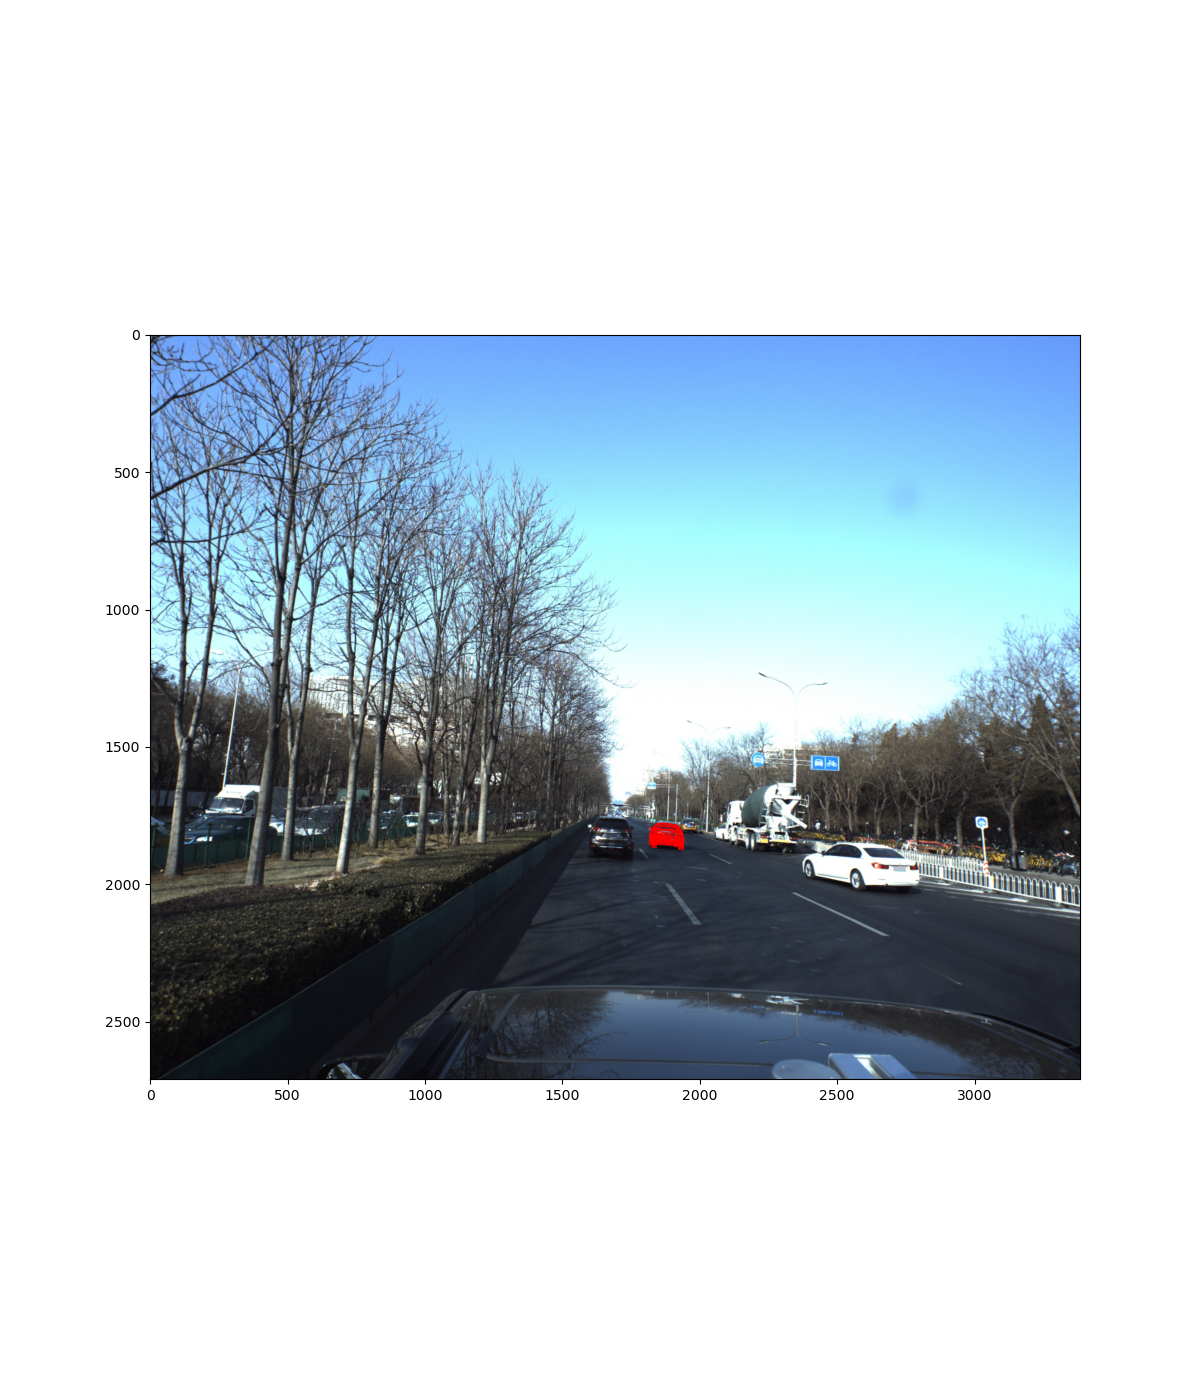

In [10]:
%matplotlib widget
image = images[1]

plt.figure(figsize=(12,14))
plt.imshow(image)
plt.show()